# Policy Gradient
よい実装（このままだと動かない）: https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf

In [1]:
from collections import namedtuple, deque
from itertools import count
import random
import copy

import gym
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions.categorical import Categorical

plt.rcParams['font.family'] = 'MyricaM M'

In [2]:
# ハイパラ
N_EPISODES = 500
learning_rate = 0.01
N_HIDDEN = 128
gamma = 0.99

env = gym.make('CartPole-v0')
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
reward_threshold = env.spec.reward_threshold

np.random.seed(123)
env.seed(123)
torch.manual_seed(123)

In [3]:
class PolicyNet(nn.Module):
    def __init__(self, in_dim, out_dim, h_dim=128):
        super(PolicyNet, self).__init__()
        self.l1 = nn.Linear(in_dim, h_dim)
        self.l2 = nn.Linear(h_dim, out_dim)
        

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = self.l2(h)
        prob = F.softmax(h, dim=-1) # softmaxで確率表現
        dist = Categorical(prob)
        return dist


policy = PolicyNet(obs_size, n_actions)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

In [4]:
def select_action(policy, state):
    # 状態を受け取って行動とそのlog_probを返す。
    state = torch.from_numpy(state).float().unsqueeze(0)
    dist = policy(state)
    action = dist.sample()
    log_prob = dist.log_prob(action)
    
    return action.item(), dist.log_prob(action)

In [5]:
def update_policy(policy, reward_episode, policy_history):
    '''
    報酬の実績と方策のlog_probから勾配を計算し、方策を更新
    '''

    R = 0
    rewards = deque()
    losses = []

    # 報酬の実績から割引報酬を算出する.
    # 逆順で取り出してくることで、R0 = r1 + gamma*r2 + ...
    for r in reward_episode[::-1]:
        R = r + gamma * R
        rewards.appendleft(R)

    # rewardのスケーリング
    rewards = torch.tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    for l_p, r in zip(policy_history, rewards):
        losses.append(-l_p * r)

    # 損失関数の関数と方策の更新
    optimizer.zero_grad()
    loss = torch.cat(losses).sum()
    loss.backward()
    optimizer.step()

In [6]:
render = False

reward_history = [] # reward_history: エピソードごとのトータルの報酬

for ep in range(N_EPISODES):
    policy_history = [] # policy_history: log_probの履歴保存
    reward_episode = [] # reward_episode: 1エピソードの報酬履歴
    state = env.reset()
    if render:
        env.render()

    done = False
    
    # エピソード終了まで動かす（Monte-Carlo）
    while not done:
        action, log_prob = select_action(policy, state)
        state, reward, done, _ = env.step(action)
        
        # save reward
        reward_episode.append(reward)
        policy_history.append(log_prob)
    
    R = np.sum(reward_episode)  # 1エピソードで獲得した報酬
    reward_history.append(R)

    update_policy(policy, reward_episode, policy_history)

    if ep % 50 == 0:
        print('Episode: {},  \t Reward: {:2f}'.format(ep, R))
    

Episode: 0,  	 Reward: 12.000000
Episode: 50,  	 Reward: 46.000000
Episode: 100,  	 Reward: 200.000000
Episode: 150,  	 Reward: 200.000000
Episode: 200,  	 Reward: 200.000000
Episode: 250,  	 Reward: 200.000000
Episode: 300,  	 Reward: 200.000000
Episode: 350,  	 Reward: 110.000000
Episode: 400,  	 Reward: 120.000000
Episode: 450,  	 Reward: 44.000000


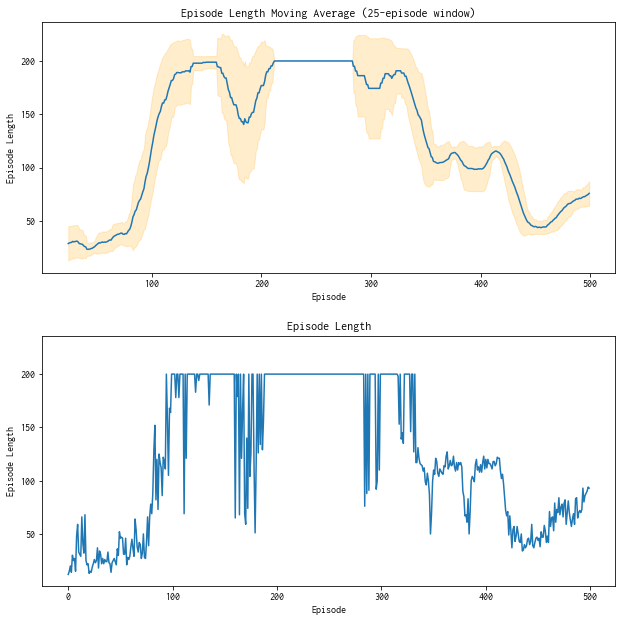

In [8]:
window = int(N_EPISODES/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9])
rolling_mean = pd.Series(reward_history).rolling(window).mean()
std = pd.Series(reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.savefig('images/reinforce.png')
plt.show()